# Pairs trading model based on stochastic optimal control

In this notebook, we look at how the theoretical model performs in historical empirical data.


### Load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load historical data
data = pd.read_csv('./data/data.csv.gz', index_col=0, header=0)
data.index = pd.DatetimeIndex(data.index)

print(data.head())

                       XBTUSD    BCHUSD    ETHUSD   XRPUSD
time                                                      
2021-05-10 00:00:02  58428.75  1435.300  3930.125  1.53985
2021-05-10 00:01:02  58428.75  1440.025  3925.775  1.54025
2021-05-10 00:02:02  58394.25  1443.475  3922.125  1.54125
2021-05-10 00:03:02  58330.75  1440.650  3920.075  1.54135
2021-05-10 00:04:02  58290.75  1443.075  3918.025  1.53810


### Estimate correlations

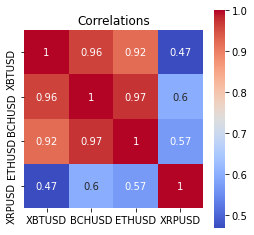

In [2]:

# Correlation matrix
corrmat = data.corr()


f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(corrmat, annot=True, square=True, cmap="coolwarm")
ax.set_title('Correlations')
plt.show()

### Selecting trading assets

Here we select traded assets based on simple Pearson correlation coefficient. It seems that BCHUSD and ETHUSD have relatively high positive correlation.


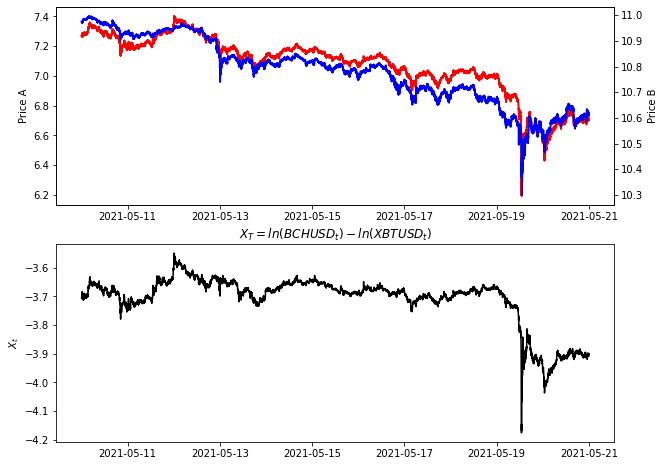

In [31]:
symbol_A = 'BCHUSD'
symbol_B = 'XBTUSD'

prices_A = data[symbol_A]
prices_B = data[symbol_B]

X_t = np.log(prices_A) - np.log(prices_B)

f, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot prices
ax[0].plot(np.log(prices_A), color='red', label='Price A', lw=2)
ax[0].set_ylabel('Price A')
ax2 = ax[0].twinx()
ax2.plot(np.log(prices_B), color='blue', label='Price B', lw=2)
ax2.set_ylabel('Price B')

# Plot spread
ax[1].plot(X_t, color='black')
ax[1].set_title(f'$X_T = ln({symbol_A}_t) - ln({symbol_B}_t)$')
ax[1].set_ylabel(r'$X_t$')
plt.show()

### Estimate OU parameters

In [48]:
from src.optimal_controls.ou_params import OrnsteinUhlenbeckProcessParameters

sample_size = int(0.5*len(prices_A)) # % of the total amount of data

sample_prices_A = prices_A.iloc[0:sample_size]
sample_prices_B = prices_B.iloc[0:sample_size]

model_params = OrnsteinUhlenbeckProcessParameters.ols_parameter_estimation(
    sample_prices_A, sample_prices_B, 1.0/(24.0*60.0))

print('Estimated theta:', model_params.theta)
print('Estimated eta:', model_params.eta)
print('Estimated kappa:', model_params.kappa)


Estimated theta: -3.6649447144311553
Estimated eta: 0.08182136907394441
Estimated kappa: 2.9541870163515918


### Strategy parameters


In [53]:
from src.optimal_controls.ou_spread_model_parameters import OUSpreadModelStrategyParameters

nominal      = 1000000
horizon      = 1
risk_tol     = -float(10)  # risk penalty parameter
max_leverage = 2

strat_params = OUSpreadModelStrategyParameters(nominal, symbol_A, symbol_B, horizon, risk_tol, max_leverage)


In [54]:
from src.simulation.simulate_pairs_trading import simulate_pairs_trading
from src.portfolio.contract import Contract

futures_A = Contract(symbol_A, 'F', 1)
futures_B = Contract(symbol_B, 'F', 1)

portfolio = simulate_pairs_trading(
                model_params,
                strat_params,
                prices_A.values,
                prices_B.values,
                X_t, horizon, 1.0/len(prices_A),
                futures_A,
                futures_B, 
                len(prices_A),
                1)


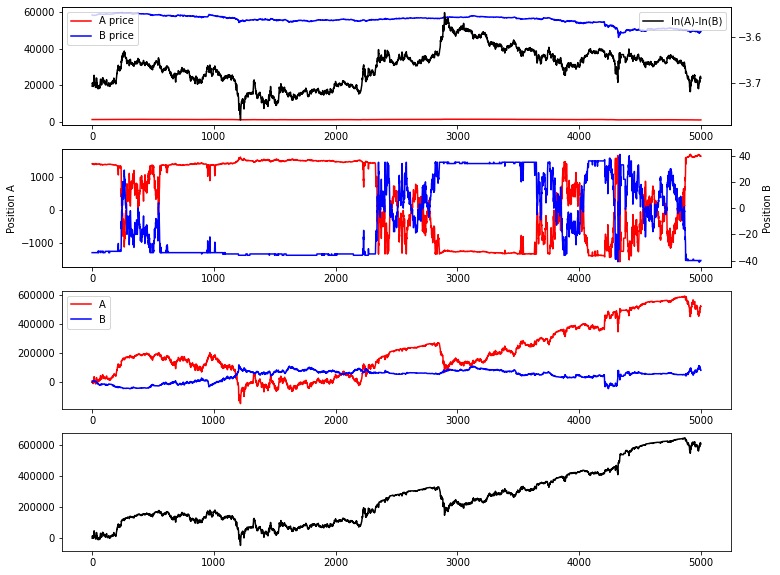

In [55]:
report_A = portfolio.get_position(symbol_A).generate_report_frame()
report_B = portfolio.get_position(symbol_B).generate_report_frame()

N_plotted = 5000

fig, ax = plt.subplots(4, 1, figsize=(12, 10))
    
# Plot asset prices
ax[0].plot(prices_A.values[0:N_plotted], color='red', label='A price')
ax[0].plot(prices_B.values[0:N_plotted], color='blue', label='B price')
ax[0].legend(loc=2)
    
# Plot logarithmic spread
ax02 = ax[0].twinx()
ax02.plot(np.log(prices_A.values[0:N_plotted]) - np.log(prices_B.values[0:N_plotted]),
          color='black', label='ln(A)-ln(B)')
ax02.legend(loc=1)

# Plot positions
ax[1].plot(report_A['NET_POSITION'].values[0:N_plotted], color='red', label='A')
ax[1].set_ylabel('Position A')
                 
ax12 = ax[1].twinx()
ax12.plot(report_B['NET_POSITION'].values[0:N_plotted], color='blue', label='B')
ax12.set_ylabel('Position B')
    
# Plot profit and loss 
ax[2].plot(report_A['TOTAL_PNL'].values[0:N_plotted], color='red', label='A')
ax[2].plot(report_B['TOTAL_PNL'].values[0:N_plotted], color='blue', label='B')
ax[2].legend(loc=2)


ax[3].plot((report_A['TOTAL_PNL'] + report_B['TOTAL_PNL']).values[0:N_plotted],
          color='black', label='A+B')

